# Kaggle stroke dataset Jupyter Notebook

This Jupyter Notebook contains 

 - some basic data analysis, 
 - visualization, 
 - a random forest model for new classifications, 
 - and an example of oversampling for unbalanced class representation on the Kaggle **stroke dataset**.

First we import pandas so we can create dataframes, and matplotlib's pyplot for visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

We read the data from the downloaded *csv* file, and print the first 5 rows. This way we can see the basic structure and a little representation of the values from each row.

In [2]:
csv_data = pd.read_csv('stroke-data.csv')

print(csv_data.head(5))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


Next we check a basic description of our numeric columns. We can see the 3 quartiles of our numeric data, the mean, max-min values and the corrected sample standard deviation.

We also check the number of missing values in each column. Luckily only the "**bmi**" column is missing some, and not too many either.

In [3]:
print("5 measure description of the numeric values:\n")
print(csv_data[["age","avg_glucose_level","bmi"]].describe())
print("\nHow many NA values are in each column?\n")
print(csv_data.isna().sum())

5 measure description of the numeric values:

               age  avg_glucose_level          bmi
count  5110.000000        5110.000000  4909.000000
mean     43.226614         106.147677    28.893237
std      22.612647          45.283560     7.854067
min       0.080000          55.120000    10.300000
25%      25.000000          77.245000    23.500000
50%      45.000000          91.885000    28.100000
75%      61.000000         114.090000    33.100000
max      82.000000         271.740000    97.600000

How many NA values are in each column?

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


We can fill these missing values with the average *body mass index* value from the dataset.

In [4]:
csv_data.bmi = csv_data.bmi.fillna(value=round(csv_data.bmi.mean(), 1))

Most of our variables are categorical, and some are even text based. 

The following three variables have two possible values. For example a person's gender in the dataset can be 'Male' or 'Female', type of residence could be 'Urban' or 'Rural'. By using the *get_dummies* method from pandas we can transform the columns into a numeric format. If a person's gender is 'Male', they get a value of '1', if they are female they get '0'. We use the same formula for the other two columns.

In [5]:
isMale = csv_data.gender.str.get_dummies(sep='|')['Male']
wasMarried = csv_data.ever_married.str.get_dummies(sep='|')['Yes']
isUrban = csv_data.Residence_type.str.get_dummies(sep='|')['Urban']

Next we get the variables which have more than two possible outcomes. These are the type of work a person does for a living, and their history of smoking tobacco.

The dataset contains some people who have never worked before, but who are also not children. There are not many people who represent this group, so for dimensionality reduction reasons we can combine these two possibilities. (children and people who have never worked)

In [6]:
workType = csv_data.work_type.str.get_dummies(sep='|')
smokerStatus = csv_data.smoking_status.str.get_dummies(sep='|')

neverWorked = workType["Never_worked"]

for i in range(len(workType)):
    if workType["children"][i] == 1:
        neverWorked[i] = 1

For now, we are done with dropping and combining columns. Now we shall concatenate the datasets containing the previous dummy variables with the original dataset's numeric values. Then I decided to rewrite the column names into a more unified "camelCase" style. 

Also, we can drop the "Unknown" column from the smokers, and if the person has '0' at every other value, we know that we do not know about their history of smoking.

In [7]:
all_data = pd.concat([csv_data[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"]], 
                      isMale, isUrban, smokerStatus[["formerly smoked", "never smoked", "smokes"]], wasMarried, 
                      workType[["Govt_job", "Never_worked", "Private", "Self-employed"]], csv_data[["stroke"]]], axis = 1)

all_data = all_data.rename(columns = {"heart_disease" : "heartDisease", "avg_glucose_level" : "avgGlucLevel", "Male" : "isMale",
                              "Urban" : "isUrban", "formerly smoked" : "smokingFormer",
                              "never smoked" : "smokingNever", "Yes" : "wasMarried", "Govt_job" : "jobGovt",
                              "Never_worked" : "jobNever", "Private" : "jobPrivate", "Self-employed" : "jobSelf"})


Naturally, the different types of jobs each have a different number of representatives in the dataset. This means, that if we would plot the number of people who had a stroke within the different occupations, we would not get an accurate representation of how a person's job can change their chance of getting one. So I decided to use the **ratio** of stroke sufferers in each group.

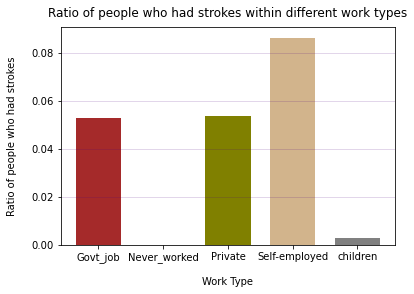


Number of representatives of each job type: 
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Number of stroke sufferers within different work types: 
Private          149
Self-employed     65
Govt_job          33
children           2
Name: work_type, dtype: int64

Ratios of stroke sufferers: 
Govt_job         0.052885
Never_worked          NaN
Private          0.053674
Self-employed    0.086207
children         0.002920
Name: work_type, dtype: float64


In [8]:
work_s = csv_data.query('stroke == 1')['work_type'].value_counts()
work_no_s = csv_data.query('stroke == 0')['work_type'].value_counts()
work_ratios = work_s/work_no_s

#csv_data.query('stroke == 1')['work_type'].value_counts().plot(kind='bar', figsize=(7, 6), color=['brown', 'olive', 'tan', 'gray'])
plt.bar(work_ratios.index, work_ratios, width = 0.7, color=['brown', 'black', 'olive', 'tan', 'gray'])
plt.xlabel("Work Type", labelpad=14)
plt.ylabel("Ratio of people who had strokes", labelpad=14)
plt.grid(True, color = 'indigo', alpha = 0.2, axis = 'y')
plt.title("Ratio of people who had strokes within different work types", y=1.02)
plt.show()


print("\nNumber of representatives of each job type: ")
print(csv_data['work_type'].value_counts())

print("\nNumber of stroke sufferers within different work types: ")
print(work_s)

print("\nRatios of stroke sufferers: ")
print(work_ratios)

The next plot shows the distribution of "age bins" (five per decade) in the dataset. As we can see we have a mostly normal looking distribution, but there are also many people in the first and last quartile.

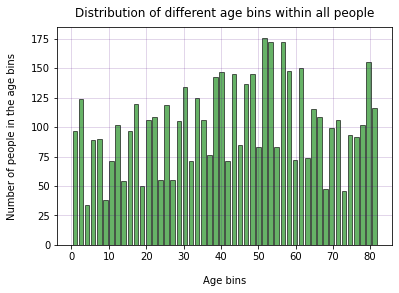

The average age of a person in the dataset: 43.226614481409


In [9]:
plt.hist(all_data["age"], bins=50, density=False, histtype='bar', align='mid', orientation='vertical', facecolor='green', ec='black', alpha = 0.60, rwidth=0.75)
plt.grid(True, color = 'indigo', alpha = 0.2)
plt.xlabel("Age bins", labelpad=14)
plt.ylabel("Number of people in the age bins", labelpad=14)
plt.title("Distribution of different age bins within all people", y=1.02)
plt.show()

print("The average age of a person in the dataset: {}".format(all_data["age"].mean()))

As we can see in the next section, the average stroke-sufferer is ~24 years older than the global average. We can also see that the average age of a person who didn't suffer a stroke is almost equal to the global average. The plot just shows the age bins of stroke sufferers, and it helps explain the difference between the ages.

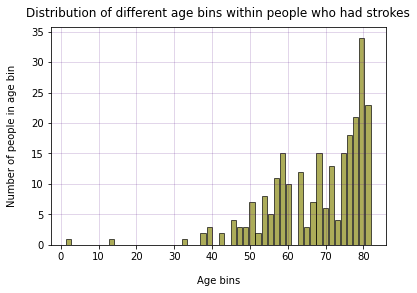

The average age of a person who suffered a stroke: 67.72819277108434
The average age of a person who never suffered a stroke: 41.971544949598844


In [10]:
plt.hist(all_data.query('stroke == 1')["age"], bins=50, density=False, histtype='bar', align='mid', orientation='vertical', facecolor='olive', ec='black', alpha = 0.65, rwidth=0.85)
plt.grid(True, color = 'indigo', alpha = 0.2)
plt.xlabel("Age bins", labelpad=14)
plt.ylabel("Number of people in age bin", labelpad=14)
plt.title("Distribution of different age bins within people who had strokes", y=1.02)
plt.show()

print("The average age of a person who suffered a stroke: {}".format(all_data.query('stroke == 1')["age"].mean()))
print("The average age of a person who never suffered a stroke: {}".format(all_data.query('stroke == 0')["age"].mean()))

Similarly to job types, "smoking status" also has a different count of representatives. We can use the same technique here, by checking the ratios. As we can see, most people in our dataset have never smoked, but on our plot we can see that most stroke sufferers have a "former smoker" status.

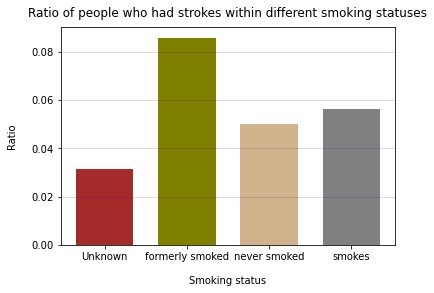


Number of people within each smoking status: 
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [11]:
smoke_stroke = csv_data.query('stroke == 1')['smoking_status'].value_counts()
smoke_no_stroke = csv_data.query('stroke == 0')['smoking_status'].value_counts()
smoke_ratios = smoke_stroke/smoke_no_stroke 

# plotting the ratio
plt.bar(smoke_ratios.index, smoke_ratios, width = 0.7, color=['brown', 'olive', 'tan', 'gray'])
plt.xlabel("Smoking status", labelpad=14)
plt.ylabel("Ratio", labelpad=14)
plt.grid(True, color = 'indigo', alpha = 0.2, axis = 'y')
plt.title("Ratio of people who had strokes within different smoking statuses", y=1.02)
plt.show()

print("\nNumber of people within each smoking status: ")
print(csv_data['smoking_status'].value_counts())

Next, we get the "stroke" variable from the dataset, these will be our labels for the model to predict.

In [12]:
all_labels = all_data.stroke
all_data = all_data.drop('stroke', axis = 1)

Due to a **very** imbalanced dataset, we have much less people who had strokes in our dataset than others. This usually results in our models overfitting the data.

For a quick solution we import "SMOTE" from the "imbalanced-learn" library, and oversample our dataset. By doing this we get an equal amount of each class (stroke and no stroke), but most stroke sufferers are artificially created. As we can see the average of stroke sufferer is still much older than others, even after oversampling.

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
# returns the resampled dataset and labels
all_data_oversampled, all_labels_oversampled = sm.fit_resample(all_data, all_labels)

print("After OverSampling, the shape of train_X: {}".format(all_data_oversampled.shape))
print("After OverSampling, the shape of train_y: {} \n".format(all_labels_oversampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(all_labels_oversampled==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(all_labels_oversampled==0)))

all_data = pd.concat([all_data_oversampled, all_labels_oversampled], axis=1)

print("The average age of a person who suffered a stroke: {}".format(all_data.query('stroke == 1')["age"].mean()))
print("The average age of a person who never suffered a stroke: {} \n".format(all_data.query('stroke == 0')["age"].mean()))

print("5 measure description of the numeric values:\n")
print(all_data[["age","avgGlucLevel","bmi"]].describe())

After OverSampling, the shape of train_X: (9722, 15)
After OverSampling, the shape of train_y: (9722,) 

After OverSampling, counts of label '1': 4861
After OverSampling, counts of label '0': 4861 

The average age of a person who suffered a stroke: 68.16524149812224
The average age of a person who never suffered a stroke: 41.971544949598844 

5 measure description of the numeric values:

               age  avgGlucLevel          bmi
count  9722.000000   9722.000000  9722.000000
mean     55.068393    118.194757    29.393128
std      22.132282     55.023037     6.581078
min       0.080000     55.120000    10.300000
25%      42.000000     78.260000    25.600000
50%      59.027857     96.356385    28.900000
75%      75.000000    143.861502    32.300000
max      82.000000    271.740000    97.600000


We scale the numeric variables by their minimum and maximum values. The highest value in each column gets '1.0', the lowest '0.0' and the others are in-between.

In [14]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

all_data.age = scaler.fit_transform(all_data[["age"]])
all_data.bmi = scaler.fit_transform(all_data[["bmi"]])
all_data.avgGlucLevel = scaler.fit_transform(all_data[["avgGlucLevel"]])

Next we shuffle our dataframe. The "stroke" label had to be re-attached to the dataframe for the shuffling, but we drop it again. Then we create our **train-** and **test set** with a 70 to 30 ratio.

In [15]:
all_data = all_data.sample(frac = 1)

all_labels = all_data.stroke
all_data = all_data.drop('stroke', axis = 1)

# 70% train data
train_data = all_data.head(int(len(all_labels_oversampled)*(70/100)))
train_labels = all_labels.head(int(len(all_labels_oversampled)*(70/100)))

# 30% test data
test_data = all_data.tail(int(len(all_data_oversampled)*(30/100)))
test_labels = all_labels.tail(int(len(all_data_oversampled)*(30/100)))

Let's check the number of rows, and the sums of the one-hot variables in each set. The basically shows how many times we have "1" in each column.

In [16]:
#checking the ratios
to_print = ["heartDisease", "isMale", "isUrban", "smokingFormer", "smokingNever", "smokes", "wasMarried", "jobGovt", "jobNever", "jobPrivate", "jobSelf"]

print("\nAll data dummies sum of {} people: \n".format(len(all_data)))
print(all_data[to_print].sum())
print("\nTrain data dummies sum of {} people: \n".format(len(train_data)))
print(train_data[to_print].sum())
print("\nTest data dummies sum of {} people: \n".format(len(test_data)))
print(test_data[to_print].sum())


All data dummies sum of 9722 people: 

heartDisease      470
isMale           3110
isUrban          3992
smokingFormer    1238
smokingNever     2587
smokes            944
wasMarried       7030
jobGovt           708
jobNever          714
jobPrivate       4724
jobSelf          1178
dtype: int64

Train data dummies sum of 6805 people: 

heartDisease      328
isMale           2167
isUrban          2771
smokingFormer     858
smokingNever     1858
smokes            648
wasMarried       4938
jobGovt           480
jobNever          490
jobPrivate       3337
jobSelf           848
dtype: int64

Test data dummies sum of 2916 people: 

heartDisease      142
isMale            943
isUrban          1221
smokingFormer     380
smokingNever      728
smokes            296
wasMarried       2091
jobGovt           228
jobNever          224
jobPrivate       1387
jobSelf           329
dtype: int64


We import a method for creating a **random forest classifier** from *sklearn*. Then, we can create a random forest classifier, with bootstrapping enabled, and equal class weights. Bootstrapping basically means that when we train our model on our data, we do it with *replacement*. So each data point in the training set can be used multiple times during training, creating multiple *random training sets*.

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(bootstrap = True, class_weight={0:1,1:1})

Next, we check the *predictive power* of our variables. Since the model returns different answers each time we *fit* it to the data, we do this multiple (now 16) times, then collect the averages.

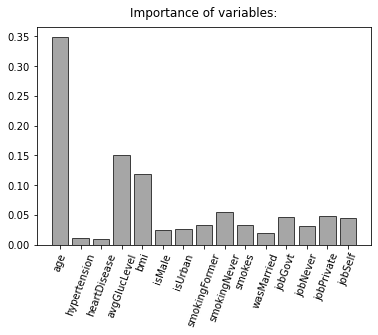

Feature: 0, Score: 0.34823
Feature: 1, Score: 0.01069
Feature: 2, Score: 0.01012
Feature: 3, Score: 0.15077
Feature: 4, Score: 0.11846
Feature: 5, Score: 0.02501
Feature: 6, Score: 0.02596
Feature: 7, Score: 0.03300
Feature: 8, Score: 0.05403
Feature: 9, Score: 0.03223
Feature: 10, Score: 0.01955
Feature: 11, Score: 0.04668
Feature: 12, Score: 0.03161
Feature: 13, Score: 0.04883
Feature: 14, Score: 0.04484


In [18]:
importance = [0] * 15

for i in range(16):
    model.fit(all_data, all_labels)
    # sum importance levels of the variables in different epochs
    #print(importance)
    importance = importance + model.feature_importances_
    
importance = importance / 16

plt.bar([x for x in range(len(importance))], importance, color = 'gray', ec='black', alpha = 0.70)
plt.xticks([x for x in range(len(importance))], all_data.columns, rotation = 70)
plt.title("Importance of variables:", y=1.02)
plt.show()

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Now we make predictions on our **test data**, after fitting the model on our **train data**.

In [19]:
model.fit(train_data, train_labels)

results = model.predict(test_data)

We import *metrics* from *sklearn* for it's **confusion matrix** and **accuracy** methods. 

As we can see, the model seems to fit our data very well. On our matrix plot, black means a lower number of predictions, white means a higher one. We can see, that most of the time our model predicted the correct label. Without oversampling the true cases, this model would overfit the data and would predict that a person won't have a stroke in almost every single case. 

Next we can print the **accuracy score** of the model, which fluctuates between **~91-96%**.

**Plot Explanation:**
**(Left top: True Positive, Left Bottom: False Negative, Right top: False Positive, Right Bottom: True Negative)**

**Formula for calculating accuracy:**
**Accuracy = TP + TN / (TP + FP + FN + TN); so basically the ratio of correct predictions to all predictions.**

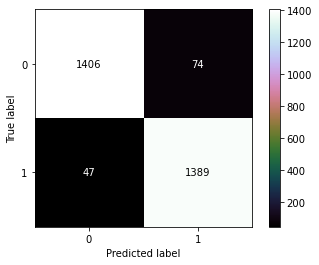

Final accuracy score: 0.9585048010973937


In [20]:
from sklearn import metrics as skm

skm.confusion_matrix(results, test_labels, labels=None, sample_weight=None, normalize=None)

skm.plot_confusion_matrix(model, test_data, test_labels, cmap=plt.cm.cubehelix)
plt.show()

print("Final accuracy score: {}".format(skm.accuracy_score(results, test_labels)))

Thank you for running my notebook.